# Random Survival Forest model

Feature selection with RSF in Owkin dataset.

External packages.

In [0]:
!pip install scikit-survival
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import read_data

## Load data

In [0]:
features = ['original_shape_Compactness2',
 'original_shape_SphericalDisproportion',
 'original_shape_SurfaceVolumeRatio',
 'original_firstorder_Kurtosis',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Minimum',
 'original_glcm_ClusterProminence',
 'original_glcm_Contrast',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceAverage',
 'original_glcm_JointEnergy',
 'original_glcm_Id',
 'original_glcm_Idm',
 'original_glcm_Imc1',
 'original_glcm_Imc2',
 'original_glcm_Idmn',
 'original_glcm_Idn',
 'original_glrlm_ShortRunEmphasis',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_RunPercentage',
 'original_glrlm_ShortRunLowGrayLevelEmphasis',
 'original_glrlm_LongRunLowGrayLevelEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'Nstage',
 'age',
 'SourceDataset_l1',
 'SourceDataset_l2']

In [0]:
radiomics_path = 'radiomics.csv'
clinical_path = 'clinical_data_cleaned.csv'
label_path = 'y_train.csv'

def load_data(features=None):
    X_df, y_df = read_data.load_owkin_data(radiomics_path, clinical_path, label_path)
    if features != None:
        X_df = X_df[features]
    X = X_df.to_numpy()
    y = read_data.y_dataframe_to_rsf_input(y_df)
    return X_df, y_df, X, y

X_df, y_df, X, y = load_data(features)
feature_name = list(X_df.columns.values)
X_df

,original_shape_Compactness2,original_shape_SphericalDisproportion,original_shape_SurfaceVolumeRatio,original_firstorder_Kurtosis,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Minimum,original_glcm_ClusterProminence,original_glcm_Contrast,original_glcm_DifferenceEntropy,original_glcm_DifferenceAverage,original_glcm_JointEnergy,original_glcm_Id,original_glcm_Idm,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idmn,original_glcm_Idn,original_glrlm_ShortRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunPercentage,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Nstage,age,SourceDataset_l1,SourceDataset_l2
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202,0.274892,1.537964,0.275228,1.592466,288.311105,-1006.0,546253.499762,54.336816,3.845383,5.036775,0.005920,0.338672,0.262780,-0.175185,0.901525,0.981053,0.917509,0.926391,1.457980,555.378594,0.891330,0.003384,0.004444,1651.710761,0,66.0000,0,1
371,0.188210,1.744961,0.240727,3.371013,191.395154,-945.0,331155.230396,16.868781,2.984034,2.570017,0.025532,0.495719,0.439879,-0.250370,0.932847,0.993282,0.953464,0.855154,2.512125,1766.619373,0.766032,0.002069,0.003633,3386.995589,2,64.5722,1,0
246,0.265740,1.555420,0.200766,7.585494,94.132136,-785.0,54523.086867,7.040623,2.333939,1.496020,0.066569,0.616607,0.581458,-0.249969,0.884911,0.995095,0.963887,0.769265,4.096838,3462.816344,0.644554,0.001635,0.004869,4232.418080,3,66.0452,1,0
240,0.255406,1.576120,0.323878,4.281865,149.072998,-850.0,166735.779994,13.656782,2.926791,2.492079,0.015048,0.457545,0.391681,-0.214233,0.902811,0.993509,0.950374,0.880123,1.824328,683.869792,0.828138,0.002680,0.003901,1844.746046,2,59.3566,1,0
284,0.199424,1.711620,0.327241,8.999616,143.210231,-1023.0,658805.553990,20.121147,2.787526,2.372269,0.029317,0.544607,0.501892,-0.238174,0.911356,0.992658,0.958908,0.819049,2.652580,962.094760,0.734898,0.004704,0.023273,4444.272812,3,71.0554,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.250187,1.587005,0.286576,1.927350,233.308909,-1015.0,367468.618766,28.824354,3.484871,3.972802,0.001746,0.336821,0.249734,-0.214544,0.939555,0.988997,0.930211,0.934151,1.351356,454.228333,0.907916,0.003590,0.005985,1145.996232,2,69.1828,1,0
261,0.454151,1.300968,0.281441,1.925799,214.212310,-901.0,227251.294990,17.384511,3.111318,2.831998,0.016200,0.451176,0.383987,-0.271559,0.953994,0.990157,0.939545,0.885250,2.126745,336.573622,0.807157,0.002829,0.004400,2243.689318,0,87.1266,1,0
129,0.234096,1.622565,0.224665,51.791276,27.675471,-751.0,6889.281619,1.439822,1.440679,0.633557,0.130721,0.746369,0.735862,-0.264988,0.824795,0.999412,0.987616,0.631183,7.254939,4513.100699,0.511173,0.000784,0.006983,7752.599509,1,59.8439,1,0


## Selection via permutation importance
See https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

In [0]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV

Random search for parameters of the random forest, with all features.

In [0]:
tuned_params = {"n_estimators": [10, 50, 100, 200, 500],
                "min_samples_split": [2, 5, 10, 20, 40],
                "min_samples_leaf": [1, 2, 4, 8, 16]
                }

In [0]:
search = RandomizedSearchCV(RandomSurvivalForest(), tuned_params, cv=5, verbose=2, n_jobs=-1, n_iter=50)
search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomSurvivalForest(bootstrap=True,
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  min_samples_leaf=3,
                                                  min_samples_split=6,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=None, verbose=0,
                                                  warm_start=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4, 8, 16],
                   

In [0]:
import json
with open('best_params.json', 'w') as fp:
    json.dump(search.best_params_, fp)

search.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}

In [0]:
search.best_score_

0.681492222449054

Creating best model from tuning.

In [0]:
params = search.best_params_
rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                           min_samples_split = params['min_samples_split'],
                           min_samples_leaf = params['min_samples_leaf'],
                           max_features="sqrt",
                           n_jobs=-1
                           )
cross_validate(rsf, X, y, cv=5)

{'fit_time': array([0.22310948, 0.20801306, 0.21998215, 0.22359776, 0.21602607]),
 'score_time': array([0.10423088, 0.10348821, 0.10338593, 0.10330081, 0.11683774]),
 'test_score': array([0.71041667, 0.65082109, 0.58180367, 0.6196319 , 0.67475728])}

Feature importances are computed for a sequence of estimators trained and evaluated on train/test splits according to ``cv``, and then averaged.

In [0]:
perm = PermutationImportance(rsf, cv=5)
perm.fit(X, y)
sel = SelectFromModel(perm, prefit=True)

In [0]:
X_best = sel.transform(X)
id_features = sel.get_support(indices=True)
best_features = [feature_name[id] for id in id_features]
best_features

['original_shape_SurfaceVolumeRatio',
 'original_firstorder_Minimum',
 'original_glcm_ClusterProminence',
 'original_glcm_JointEnergy',
 'original_glcm_Idm',
 'original_glcm_Imc1',
 'original_glrlm_ShortRunEmphasis',
 'original_glrlm_LongRunEmphasis',
 'original_glrlm_GrayLevelNonUniformity',
 'original_glrlm_ShortRunLowGrayLevelEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'Nstage',
 'SourceDataset_l2']

Problem of the feature selection by permutation importance: the errors (std) on the feature importance weights are too high, and the computed feature importance weights don't make sense.

In [0]:
for id in id_features:
    print(f'{feature_name[id]}: {perm.feature_importances_[id]} +/- {perm.feature_importances_std_[id]}')

original_shape_SurfaceVolumeRatio: 0.020968142322508116 +/- 0.01987413782583521
original_firstorder_Minimum: 0.004782756396357914 +/- 0.012517019893694161
original_glcm_ClusterProminence: 0.0028753696565334552 +/- 0.014174580908375901
original_glcm_JointEnergy: 0.00710193285525678 +/- 0.009908880621070757
original_glcm_Idm: 0.005363079617221596 +/- 0.01372982140990025
original_glcm_Imc1: 0.009299617695135192 +/- 0.024793343027533932
original_glrlm_ShortRunEmphasis: 0.013550379256367803 +/- 0.02382858097433002
original_glrlm_LongRunEmphasis: 0.020862170600605516 +/- 0.012444436857730468
original_glrlm_GrayLevelNonUniformity: 0.016629158199686443 +/- 0.020176409780966232
original_glrlm_ShortRunLowGrayLevelEmphasis: 0.0037956133982889415 +/- 0.01722860897105692
original_glrlm_LongRunHighGrayLevelEmphasis: 0.00821198522155985 +/- 0.01777512119568821
Nstage: 0.003868734861434109 +/- 0.011216352542439795
SourceDataset_l2: 0.00734324786519267 +/- 0.010657670355138135


In [0]:
best_indices = np.flip(np.argsort(perm.feature_importances_))[:len(best_features)]
[feature_name[i] for i in np.argsort(best_indices)] 

['original_shape_Compactness2',
 'original_glcm_DifferenceAverage',
 'original_glcm_Idm',
 'original_glcm_Contrast',
 'original_glcm_DifferenceEntropy',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Kurtosis',
 'original_shape_SphericalDisproportion',
 'original_shape_SurfaceVolumeRatio',
 'original_glcm_Id',
 'original_firstorder_Minimum',
 'original_glcm_JointEnergy',
 'original_glcm_ClusterProminence']

Cross validation.

In [0]:
from sklearn.model_selection import cross_validate
X_best = sel.transform(X)
cross_validate(rsf, X_best, y, cv=5)

{'fit_time': array([0.12452412, 0.13066578, 0.12156296, 0.12446737, 0.1260767 ]),
 'score_time': array([0.10334563, 0.10343194, 0.10331035, 0.10328126, 0.1031146 ]),
 'test_score': array([0.69333333, 0.66378565, 0.57222666, 0.67382413, 0.65695793])}

## Growing strategy for feature selection

Choose a set of features, fine tune, cross validate.

In [0]:
class RSFModel():

    def __init__(self, features):
        self.X_df, self.y_df, self.X, self.y = load_data(features)

    def fine_tune(self, hyperparams):
        search = RandomizedSearchCV(RandomSurvivalForest(), tuned_params, cv=5, verbose=1, n_jobs=-1, n_iter=10)
        search.fit(self.X, self.y)
        return search.best_params_

    def cross_validate(self, params):
        params = search.best_params_
        rsf = RandomSurvivalForest(n_estimators = params['n_estimators'],
                                min_samples_split = params['min_samples_split'],
                                min_samples_leaf = params['min_samples_leaf'],
                                max_features="sqrt",
                                n_jobs=-1
                                )
        return np.mean(cross_validate(rsf, X, y, cv=5)['test_score'])

In [0]:
def best_growing_features(selected_features, remaining_features, hyperparams):
    score = []
    for feature in remaining_features:
        model_features = selected_features + [feature]
        print(f'Model features: {model_features}')
        model = RSFModel(model_features)
        params = model.fine_tune(hyperparams)
        model_score = model.cross_validate(params)
        print(f'CIndex: {model_score}')
        score.append(model_score)
    max_id = np.argmax(score)
    return remaining_features[max_id], score[max_id]

Feature growth: find a set of selected features. The list of selected features are given in the order of the growth. After each growth, we compute the CIndex of the model with the selected features by cross validation.

In [0]:
import copy
max_features = 10
selected_features = []
remaining_features = copy.deepcopy(feature_name)

hyperparams = {"n_estimators": [10, 50, 100, 200, 500],
                "min_samples_split": [2, 5, 10, 20, 40],
                "min_samples_leaf": [1, 2, 4, 8, 16]
                }

score = []
for i in range(max_features):
    print(f'Growing {i+1}-th feature...\n')
    new_feature, new_score = best_growing_features(selected_features, remaining_features, hyperparams)
    score.append(new_score)
    selected_features.append(new_feature)
    remaining_features.remove(new_feature)
    print('Selected new growing feature: ' + new_feature + '\n')
selected_features, score

Growing 1-th feature...

Model features: ['original_shape_Compactness2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.9s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.7s finished


CIndex: 0.668255125000726
Model features: ['original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.641458168606933
Model features: ['original_shape_SurfaceVolumeRatio']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.3s finished


CIndex: 0.6520622648319663
Model features: ['original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished


CIndex: 0.6620346376053959
Model features: ['original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.66053307075514
Model features: ['original_firstorder_Minimum']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6373208187269601
Model features: ['original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6464345869017427
Model features: ['original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.9s finished


CIndex: 0.6486722031949121
Model features: ['original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.655411689710727
Model features: ['original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6535454318402498
Model features: ['original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6412856719019797
Model features: ['original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6457482150712742
Model features: ['original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.1s finished


CIndex: 0.656469270880619
Model features: ['original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.0s finished


CIndex: 0.663713695934673
Model features: ['original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6432562299852479
Model features: ['original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.8s finished


CIndex: 0.645192027157947
Model features: ['original_glcm_Idn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.3s finished


CIndex: 0.630047153023764
Model features: ['original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.9s finished


CIndex: 0.6439044215738351
Model features: ['original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6644781590644955
Model features: ['original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.5s finished


CIndex: 0.6432880618293775
Model features: ['original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6377557876234958
Model features: ['original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6531771453113256
Model features: ['original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.630843879263647
Model features: ['original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.5s finished


CIndex: 0.6531062616845703
Model features: ['Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6610080674472011
Model features: ['age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.5s finished


CIndex: 0.6413726941280498
Model features: ['SourceDataset_l1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6581097454458957
Model features: ['SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6432952642003361
Selected new growing feature: original_shape_Compactness2

Growing 2-th feature...

Model features: ['original_shape_Compactness2', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6651242647073013
Model features: ['original_shape_Compactness2', 'original_shape_SurfaceVolumeRatio']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.8s finished


CIndex: 0.6456137113371129
Model features: ['original_shape_Compactness2', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6574225729667444
Model features: ['original_shape_Compactness2', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.9s finished


CIndex: 0.66036935436364
Model features: ['original_shape_Compactness2', 'original_firstorder_Minimum']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6477711597801306
Model features: ['original_shape_Compactness2', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6514649487946292
Model features: ['original_shape_Compactness2', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.9s finished


CIndex: 0.6470730504017175
Model features: ['original_shape_Compactness2', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


CIndex: 0.6548124770014455
Model features: ['original_shape_Compactness2', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.3s finished


CIndex: 0.6590013436289548
Model features: ['original_shape_Compactness2', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6512023886061536
Model features: ['original_shape_Compactness2', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.641475360315751
Model features: ['original_shape_Compactness2', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.5s finished


CIndex: 0.6540737884615309
Model features: ['original_shape_Compactness2', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.3s finished


CIndex: 0.6595755300658864
Model features: ['original_shape_Compactness2', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6647215168354366
Model features: ['original_shape_Compactness2', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.3s finished


CIndex: 0.651342627179609
Model features: ['original_shape_Compactness2', 'original_glcm_Idn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.5s finished


CIndex: 0.6501124486571423
Model features: ['original_shape_Compactness2', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.1s finished


CIndex: 0.6328222152677472
Model features: ['original_shape_Compactness2', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6598622387896654
Model features: ['original_shape_Compactness2', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6445618707940186
Model features: ['original_shape_Compactness2', 'original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.8s finished


CIndex: 0.6524014810706922
Model features: ['original_shape_Compactness2', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6320387090314612
Model features: ['original_shape_Compactness2', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6476330360851696
Model features: ['original_shape_Compactness2', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.4s finished


CIndex: 0.6670932210994385
Model features: ['original_shape_Compactness2', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.4s finished


CIndex: 0.6598799078988445
Model features: ['original_shape_Compactness2', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6517814100757244
Model features: ['original_shape_Compactness2', 'SourceDataset_l1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6705034984625279
Model features: ['original_shape_Compactness2', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6513380358105194
Selected new growing feature: SourceDataset_l1

Growing 3-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6415728692391619
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.9s finished


CIndex: 0.6631818323582115
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6384153786839792
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.0s finished


CIndex: 0.641876883801129
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_firstorder_Minimum']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6542316657187583
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.633418856297596
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.7s finished


CIndex: 0.6468580547732365
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.638478295393538
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished


CIndex: 0.6349722940193099
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6539515903772191
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6521170012887875
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.626369181124789
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6579436963754846
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.3s finished


CIndex: 0.6450581361766345
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.3s finished


CIndex: 0.6452401009204051
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glcm_Idn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6530334611262925
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6559759636990118
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6445885945039107
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6337758648434746
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6514324875042824
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6381903486780197
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6505033687304297
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.6s finished


CIndex: 0.6143924740516076
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6415257725713739
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.3s finished


CIndex: 0.6437775330382668
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6543413995162223
Selected new growing feature: original_shape_SurfaceVolumeRatio

Growing 4-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.2s finished


CIndex: 0.6447133974727156
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.7s finished


CIndex: 0.6280176762161866
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


CIndex: 0.6411354658393125
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_Minimum']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6585365830755782
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.1s finished


CIndex: 0.6246973516330051
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.3s finished


CIndex: 0.6302952115593043
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6422912738365969
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.1s finished


CIndex: 0.6280211795820422
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.3s finished


CIndex: 0.6591129085154689
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6464868940951897
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6504785273536441
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.2s finished


CIndex: 0.6310197524160918
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6485088367803277
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6415561994591408
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.3s finished


CIndex: 0.6700353526862737
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6605541222403328
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.7s finished


CIndex: 0.6529417088729828
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


CIndex: 0.6384136418717073
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.0s finished


CIndex: 0.6549922168331123
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.3s finished


CIndex: 0.6568827815889188
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


CIndex: 0.6404185130686262
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.6s finished


CIndex: 0.6430673440069903
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6378951731810535
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.0s finished


CIndex: 0.6517340879834499
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.1s finished


CIndex: 0.6431448781383295
Selected new growing feature: original_glcm_Idn

Growing 5-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished


CIndex: 0.6310065562524546
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6494533791094825
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.8s finished


CIndex: 0.6464285622211989
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.1s finished


CIndex: 0.6768835309749677
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.1s finished


CIndex: 0.6580263643962103
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.4s finished


CIndex: 0.6539834361080634
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.6s finished


CIndex: 0.6638638512888428
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.3s finished


CIndex: 0.6391755679773458
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6559024129658692
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.3s finished


CIndex: 0.6468773558379797
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6585616400592593
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.645539947359713
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.9s finished


CIndex: 0.6616367591560964
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.4s finished


CIndex: 0.6491923197133298
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.7s finished


CIndex: 0.6754888410009978
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6432857629021708
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.3s finished


CIndex: 0.6406120648049114
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6132089644082993
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


CIndex: 0.6497606052618934
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.7s finished


CIndex: 0.6475144213509665
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.646330658501042
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


CIndex: 0.6508903567424602
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.4s finished


CIndex: 0.66089187937231
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.6s finished


CIndex: 0.6340649750707333
Selected new growing feature: original_firstorder_Minimum

Growing 6-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.1s finished


CIndex: 0.6438708963845137
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.3s finished


CIndex: 0.645671432525158
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.6s finished


CIndex: 0.6402632647720633
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.5s finished


CIndex: 0.6543060458892206
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.8s finished


CIndex: 0.6476542533226369
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.5s finished


CIndex: 0.672037433725073
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.6s finished


CIndex: 0.6346470434737717
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6536999491911979
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.6s finished


CIndex: 0.6519356155531815
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.3s finished


CIndex: 0.6359706632133694
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   60.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6334542836741885
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


CIndex: 0.6597615421214905
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.0s finished


CIndex: 0.6489937909340602
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.3s finished


CIndex: 0.6521456288269757
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6285623148086928
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.628459257836856
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6731385245399564
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.8s finished


CIndex: 0.6471695848249974
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.3s finished


CIndex: 0.6322635348517441
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.6s finished


CIndex: 0.6337943684314038
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.1s finished


CIndex: 0.6590232673469685
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.0s finished


CIndex: 0.6497039777954979
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.651655891929536
Selected new growing feature: original_glrlm_RunPercentage

Growing 7-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6505305517241264
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6523607601909773
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6501609280569307
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.648809607252376
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


CIndex: 0.6540529011331655
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6510308477080453
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6415228355750101
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6594980865590531
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6444737052240825
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6432613932042355
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6621799997444924
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6391928815862651
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6540348679580397
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6544075694457536
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6570961073232571
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.5s finished


CIndex: 0.6658012216968485
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.0s finished


CIndex: 0.6555960244048159
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   55.1s finished


CIndex: 0.6538551233767697
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6606809777776571
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6331919375790542
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished


CIndex: 0.6541487783084814
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6543166935201571
Selected new growing feature: original_glrlm_GrayLevelNonUniformity

Growing 8-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.3s finished


CIndex: 0.6435880292834651
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.6s finished


CIndex: 0.6528156366689855
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6499040071742639
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished


CIndex: 0.6540521565561755
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


CIndex: 0.6447869613018444
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.7s finished


CIndex: 0.6431069312892038
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


CIndex: 0.6431636221789764
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6554684695995565
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6497335647100754
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.641291929789704
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6622940561202497
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6481422502571381
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6743567424996522
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.9s finished


CIndex: 0.6536824645175667
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6352841528699844
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


CIndex: 0.6553850386819328
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6538759521301886
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6596913962687563
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished


CIndex: 0.6406058822454301
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.6s finished


CIndex: 0.6492294254906092
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.3s finished


CIndex: 0.6501886633714034
Selected new growing feature: original_glcm_Idmn

Growing 9-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6408920808089033
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.7s finished


CIndex: 0.6454697068969659
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


CIndex: 0.6508953130253752
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.0s finished


CIndex: 0.651538948742043
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6465475773936328
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.2s finished


CIndex: 0.6490130452837637
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6521799097933643
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6564178000351939
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6523726133874888
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   55.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.646038646390089
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.641130543835568
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


CIndex: 0.6359011861394965
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6531063212994896
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6393217246449815
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6522691996621252
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


CIndex: 0.6580099783382528
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


CIndex: 0.6419721910327935
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6631660349615801
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6549175817786312
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.8s finished


CIndex: 0.6567940605614707
Selected new growing feature: Nstage

Growing 10-th feature...

Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_shape_SphericalDisproportion']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


CIndex: 0.6734926653581707
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_firstorder_Kurtosis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.631644815062024
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_firstorder_MeanAbsoluteDeviation']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   58.5s finished


CIndex: 0.6398437744924247
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_ClusterProminence']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.0s finished


CIndex: 0.6487793600559588
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_Contrast']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6693273027064738
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_DifferenceEntropy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.8s finished


CIndex: 0.6395816514593193
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_DifferenceAverage']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6565903412591652
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_JointEnergy']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6405212249255315
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_Id']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


CIndex: 0.646922268914205
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_Idm']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6519100167711613
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_Imc1']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6597459697370164
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glcm_Imc2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.9s finished


CIndex: 0.6536907389294039
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glrlm_ShortRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6502592812331731
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glrlm_LongRunEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.644468027499275
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glrlm_ShortRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6507651784777961
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glrlm_LongRunLowGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.6350950457491924
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'original_glrlm_LongRunHighGrayLevelEmphasis']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


CIndex: 0.6393357304231814
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'age']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.0s finished


CIndex: 0.6517707969889683
Model features: ['original_shape_Compactness2', 'SourceDataset_l1', 'original_shape_SurfaceVolumeRatio', 'original_glcm_Idn', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_glrlm_GrayLevelNonUniformity', 'original_glcm_Idmn', 'Nstage', 'SourceDataset_l2']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CIndex: 0.64946705354424
Selected new growing feature: original_shape_SphericalDisproportion



(['original_shape_Compactness2',
  'SourceDataset_l1',
  'original_shape_SurfaceVolumeRatio',
  'original_glcm_Idn',
  'original_firstorder_Minimum',
  'original_glrlm_RunPercentage',
  'original_glrlm_GrayLevelNonUniformity',
  'original_glcm_Idmn',
  'Nstage',
  'original_shape_SphericalDisproportion'],
 [0.668255125000726,
  0.6705034984625279,
  0.6631818323582115,
  0.6700353526862737,
  0.6768835309749677,
  0.6731385245399564,
  0.6658012216968485,
  0.6743567424996522,
  0.6631660349615801,
  0.6734926653581707])

# Appendix

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [0]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.639361154044307

In [0]:
np.save([feature_name, perm.feature_importances_, perm.feature_importances_std_], "feature_importance")

AttributeError: 'PermutationImportance' object has no attribute 'feature_importances_'

In [0]:
best_indices = np.flip(np.argsort(perm.feature_importances_))[:10]
best_features = [feature_name[i] for i in best_indices]
best_features

['original_glcm_Idn',
 'original_glcm_Idmn',
 'Nstage',
 'age',
 'original_shape_VoxelVolume',
 'original_glrlm_RunLengthNonUniformity',
 'original_firstorder_Energy',
 'SourceDataset_l1',
 'original_glcm_Imc1',
 'original_glrlm_ShortRunEmphasis']

In [0]:
best_features = ['original_glcm_Idn',
 'original_glcm_Idmn',
 'Nstage',
 'age',
 'original_shape_VoxelVolume',
 'original_glrlm_RunLengthNonUniformity',
 'original_firstorder_Energy',
 'SourceDataset_l1',
 'original_glcm_Imc1',
 'original_glrlm_ShortRunEmphasis']
best_features

['original_glcm_Idn',
 'original_glcm_Idmn',
 'Nstage',
 'age',
 'original_shape_VoxelVolume',
 'original_glrlm_RunLengthNonUniformity',
 'original_firstorder_Energy',
 'SourceDataset_l1',
 'original_glcm_Imc1',
 'original_glrlm_ShortRunEmphasis']

In [0]:
import read_data
X_best_df = X_df[best_features]
X_best = X_best_df.to_numpy()
list(X_df[best_features].columns.values)

['original_glcm_Idn',
 'original_glcm_Idmn',
 'Nstage',
 'age',
 'original_shape_VoxelVolume',
 'original_glrlm_RunLengthNonUniformity',
 'original_firstorder_Energy',
 'SourceDataset_l1',
 'original_glcm_Imc1',
 'original_glrlm_ShortRunEmphasis']

In [0]:
from sklearn.model_selection import train_test_split
random_state = 20
X_best_train_df, X_best_test_df, y_train_df, y_test_df = train_test_split(X_best_df, y_df, test_size=0.25, random_state=random_state)

In [0]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)

X_best_train = X_best_train_df.to_numpy()
y_train = y_dataframe_to_rsf_input(y_train_df)
X_best_test = X_best_test_df.to_numpy()
y_test = y_dataframe_to_rsf_input(y_test_df)

rsf.fit(X_best_train, y_train)
rsf.score(X_best_test, y_test)

/home/leon/anaconda3/envs/std/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


0.7404306220095693

Cross validation

In [0]:
from sklearn.model_selection import cross_validate
cross_validate(rsf, X_best, y, cv=5)

{'fit_time': array([2.99259663, 1.20549083, 1.13966799, 1.31296301, 1.22523999]),
 'score_time': array([0.20998502, 0.2038331 , 0.20748258, 0.20694542, 0.20662284]),
 'test_score': array([0.71166667, 0.69576491, 0.60574621, 0.6993865 , 0.69255663])}

Prediction: trying on the training - testing set split

71


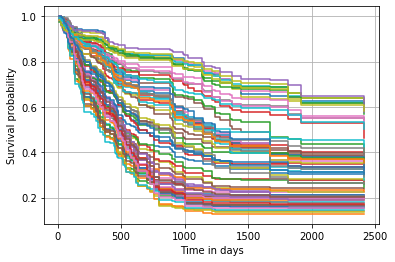

In [0]:
surv = rsf.predict_survival_function(X_best_test)
print(len(surv))

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.grid(True)

In [0]:
def predict(model, x, x_df, time, threshold = 0.89):
    surv = model.predict_survival_function(x)
    y_pred = []
    for s in surv:
        i_pred = 0
        while i_pred < len(s) - 1 and s[i_pred] > threshold:
            i_pred += 1
        y_pred.append(time[i_pred])
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=x_df.index, columns=['SurvivalTime', 'Event'])

y_pred = predict(rsf, X_best_test, X_best_test_df, rsf.event_times_)
y_pred

,SurvivalTime,Event
PatientID,,
161,131.0,NaN
112,85.0,NaN
159,79.0,NaN
88,104.0,NaN
5,131.0,NaN
...,...,...
416,98.0,NaN
343,132.0,NaN
193,319.0,NaN


In [0]:
from metrics import cindex
cindex(y_test_df, y_pred)

0.7143712574807524

Submission

In [0]:
rsf.fit(X_best, y)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [0]:
from read_data import load_submission
X_submission_df = load_submission(best_features)
X_submission_df

,original_glcm_Idn,original_glcm_Idmn,Nstage,age,original_shape_VoxelVolume,original_glrlm_RunLengthNonUniformity,original_firstorder_Energy,SourceDataset_l1,original_glcm_Imc1,original_glrlm_ShortRunEmphasis
PatientID,,,,,,,,,,
13,0.984980,0.999197,0,44.3970,254069.0,64776.697579,2.006942e+09,1,-0.306548,0.686184
155,0.891016,0.974940,3,63.3183,911.0,795.675280,2.623938e+08,1,-0.244386,0.966275
404,0.973099,0.996769,2,64.7255,39809.0,14007.509285,6.650322e+08,1,-0.241592,0.763929
407,0.970611,0.996313,0,65.3635,14458.0,6094.805584,3.754287e+08,1,-0.239166,0.791925
9,0.904510,0.978024,0,50.0000,18942.0,15924.101510,9.108915e+09,0,-0.087334,0.956571
...,...,...,...,...,...,...,...,...,...,...
66,0.988427,0.999585,2,70.7077,147333.0,64292.661837,4.677261e+09,1,-0.331101,0.801772
132,0.969797,0.995251,3,51.1595,61130.0,18707.945523,2.332008e+09,1,-0.291445,0.747388
169,0.938707,0.990300,1,70.0000,9795.0,6995.460108,2.036047e+08,0,-0.069610,0.916743


In [0]:
X_submission = X_submission_df.to_numpy()
print(X_submission == np.nan)
y_pred = predict(rsf, X_submission, X_submission_df, rsf.event_times_)
y_pred

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Grid search for tuning parameters of RSF

In [0]:
best_params = grid_search.best_params_
best_params